In [3]:
!pip install pytrends

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pytrends.request import TrendReq
import time

In [7]:
pytrends = TrendReq()

In [5]:
pytrends.build_payload(kw_list, cat=0, timeframe='2016-01-01 2017-01-01', geo='US')


NameError: name 'pytrends' is not defined

In [99]:
kw_list=["Social Security","Social Security Office Locations","Unemployment Benefits","Social Security Gov", 
         "Unemployment Office","Food Stamps", "Department of Labor"]
jobs=["Monster","Indeed","Jobs","Job Search",
         "Resume","Job Search Engines","Linkedin","Hotjobs","Cover Letter"]
print(len(kw_list))

16


In [101]:
import time

dfs=[]
# time.sleep(120)
for k in range(0,len(kw_list)):
    print(k)
    pytrends = TrendReq(hl='en-US', tz=360)
    tmpDF=None
    pytrends.build_payload([kw_list[k]], cat=0, timeframe='2004-01-01 2021-01-01', geo='US')
    yeardf=pytrends.interest_over_time()
    for i in range(4,21):
        if i<9:
            timeFrame="200"+str(i)+"-01-01 "+"200"+str(i+1)+"-01-01"
        elif i==9:
            timeFrame='2009-01-01 2010-01-01'
        elif i>-10:
            timeFrame="20"+str(i)+"-01-01 "+"20"+str(i+1)+"-01-01"
        pytrends.build_payload(kw_list[k:k+1], cat=0, timeframe=timeFrame, geo='US')
        df=pytrends.interest_over_time()
        try:
            df=df.drop(columns=["isPartial"])
        except KeyError:
            pass
        if not df.empty:
            if tmpDF  is None:
                val=max(1,yeardf[kw_list[k:k+1][0]].tolist()[(i-4)*12])
                x=df[kw_list[k:k+1][0]].tolist()[0]
                if x == 0 and val == 0:
                    val = 1
                elif x == 0:
                    x=sum(df[kw_list[k:k+1][0]].tolist()[0:11])/len(df[kw_list[k:k+1][0]].tolist()[0:11])
                    if x==0:
                        val = val/x
                    else:
                        val=1
                elif val == 0:
                    val = 1
                else:
                    val = val/x
                val=val/x
                df[kw_list[k:k+1][0]]=df[kw_list[k:k+1][0]]*val
                tmpDF= df
            else:
                val=max(1,yeardf[kw_list[k:k+1][0]].tolist()[(i-4)*12])
                x=max(1,df[kw_list[k:k+1][0]].tolist()[0])
                val=val/x
                df[kw_list[k:k+1][0]]=df[kw_list[k:k+1][0]]*val
                tmpDF=tmpDF.append(df)
    if k%5==0:
        time.sleep(60)
    dfs.append(tmpDF)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [64]:
# val=yeardf.at[yeardf.index[(i-4)*12], kw_list[3]]/100
# print(len(yeardf)%12)
# plt.plot(yeardf)
# plt.legend(yeardf.columns)

In [ ]:
# pytrends.build_payload([kw_list[2]], cat=0, timeframe='2004-01-01 2021-01-01', geo='US')
# df=pytrends.interest_over_time()
# try:
#     df=df.drop(columns=["isPartial"])
# except KeyError:
#     pass
# plt.plot(df)

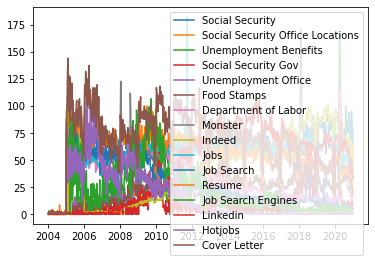

In [104]:

# tmpDF.head()
cur=dfs[0]
for i in dfs[1:len(dfs)]:
    if i is not None:
        result = pd.concat([cur, i.reindex(cur.index)], axis=1, join="inner")
        cur=result
# cur=cur.drop(columns=["Hotjobs","Monster","Job Search","Jobs"," Job Search Engines"])
# cur=pd.DataFrame(cur.sum(axis=1),columns=["Jobs"])
plt.plot(cur)
plt.legend(cur.columns)
# cur["Unemployment"]=cur["Unemployment"]

cur.tail()
cur.to_excel("Jobs.xlsx")

In [91]:
# cur=cur.drop_duplicates(subset=cur.columns[:2], keep='last')
print(len(cur))

890


In [43]:

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    index=dataset.index[interval:len(dataset)]
    columns=dataset.columns
    d={}
    for j in range(len(columns)):
        tmp=[]
        for i in range(interval, len(dataset)):
            value = dataset[columns[j]][i] - dataset[columns[j]][i - interval]
            tmp.append(value)
        d[columns[j]]=tmp
    diffs=pd.DataFrame(d)
    diffs=diffs.set_index(index)
    return (diffs)

In [44]:
df=pd.read_excel("trends.xlsx")
df=df.set_index("date")
new=difference(df)
new.to_excel("DifferencedTrends.xlsx")  

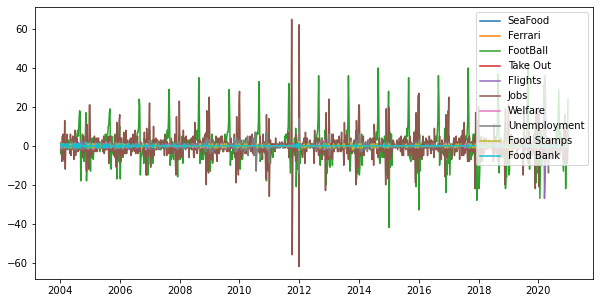

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(new.index,new)
plt.legend(new.columns)

ADF Test for:  Jobs
ADF Statistic: -14.701359
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  Welfare
ADF Statistic: -12.238815
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  Unemployment
ADF Statistic: -11.853655
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  indeed
ADF Statistic: -13.183691
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  ZipRecruiter
ADF Statistic: -7.745314
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [85]:

"""Citation: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
I used the above source to perform granger causality tests on the data"""
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(new, variables = new.columns)    

,Jobs_x,Welfare_x,Unemployment_x,indeed_x,ZipRecruiter_x
Jobs_y,1.0000,0.0000,0.5582,0.2049,0.4038
Welfare_y,0.0005,1.0000,0.1378,0.0304,0.0186
Unemployment_y,0.0000,0.0003,1.0000,0.0000,0.7043
indeed_y,0.0359,0.0000,0.2325,1.0000,0.0472
ZipRecruiter_y,0.0627,0.1028,0.8684,0.0000,1.0000


In [224]:
from datetime import date, timedelta

startDate="2015-10-24"
endDate="2020-12-26"
cur=date.fromisoformat(startDate)
prev= cur- timedelta(days=7)
end=date.fromisoformat(endDate)
index=[]
val=[]
count=0
while cur<=end:
  timeframe=str(prev)+" "+str(cur)
  try:
    pytrends.build_payload(["Economy"], cat=0, timeframe=timeframe, geo='US')
  except:
    time.sleep(60)
    try:
      pytrends.build_payload(["Economy"], cat=0, timeframe=timeframe, geo='US')
    except:
      break
  d=pytrends.related_queries()
  index.append(cur)
  if d["Economy"]["rising"] is not None:
    val.append(d["Economy"]["rising"]["value"].sum())
  else:
    val.append(0)
  cur=cur + timedelta(days=7)  
  prev= prev+ timedelta(days=7)  
  print(count)
  count+=1
  
data={"Rising Trends":val }
df = pd.DataFrame(data, index =index)
df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


,Rising Trends
2015-10-24,40
2015-10-31,250
2015-11-07,0
2015-11-14,250
2015-11-21,0


In [225]:
df.to_excel("Rising_trends_tail.xlsx")  

In [226]:
df.tail()

,Rising Trends
2020-11-28,12900
2020-12-05,850
2020-12-12,0
2020-12-19,74200
2020-12-26,0
